**author**: lukethompson@gmail.com<br>
**date**: 16 Feb 2017<br>
**language**: Python 3.5<br>
**conda environment**: emp-py3<br>
**license**: unlicensed<br>

## Refining EMP metadata (QIIME mapping files) using Pandas

### Columns in the refined mapping files

The following columns are created in the merged and individual refined mapping files.

_Sample_

* `#SampleID` -- unique identifier for sample
* `BarcodeSequence` -- Illumina barcode sequence
* `LinkerPrimerSequence` -- Illumina linker primer sequence
* `Description` -- sample description
* `host_subject_id` -- unique identifier for subject (multiple samples may come from same subject)

_Study_

* `study_id` -- parsed from SampleID
* `title` -- study title
* `principal_investigator` -- PI of the study
* `doi` -- digital object identifier (DOI) of primary publication
* `ebi_accession` -- EBI accession number if submitted
* `pcr_primers` -- amplicon primer sequences used
* `read_length_bp` -- median read length in bp after quality filtering

_Quality (not included in qc-filtered and subset mapping files)_

* `emp_paper` -- included among 97 studies in 2017 EMP paper
* `study_ok` -- study does not have major issues
* `dense_sampling` -- whether the study has highly similar samples
* `metadata_minimal` -- whether the study has only minimal metadata
* `units_status` -- whether units are provided for measurements

_Sequences_

* `sequences_split_libraries` -- number of sequences after split libraries
* `observations_closed_ref_greengenes` -- number of observations in closed-reference Greengenes table
* `observations_closed_ref_silva` -- number of observations in closed-reference Silva table
* `observations_open_ref_greengenes` -- number of observations in open-reference Greengenes table
* `observations_deblur_90bp` -- number of observations in 90-bp Deblur table
* `observations_deblur_100bp` -- number of observations in 100-bp Deblur table
* `observations_deblur_150bp` -- number of observations in 150-bp Deblur table

_Subsets_

* `all_emp` -- samples with >=1 sequences (split libraries) per sample
* `qc_filtered` -- samples with >=1000 observations in CR-GG & CR-Silva & OR-GG & Deblur-90 but excluding controls (all subsets are in this set)
* `subset_10k` -- 10000 samples with >=10000 CR-GG & CR-Silva & OR-GG and >=5000 Deblur-90, evenly distributed across `empo_3` categories and then across studies
* `subset_5k` -- 5000 samples with >=10000 CR-GG & CR-Silva & OR-GG and >=5000 Deblur-90, evenly distributed across `empo_3` categories and then across studies
* `subset_2k` -- 2000 samples with >=10000 CR-GG & CR-Silva & OR-GG and >=5000 Deblur-90, evenly distributed across `empo_3` categories and then across studies

_Taxonomy_

* `sample_taxid` -- NCBI taxonomy ID of sample
* `sample_scientific_name` -- NCBI scientific name of sample, looked up using `sample_taxid`
* `host_taxid` -- NCBI taxonomy ID of host
* `host_common_name_provided` -- user-provided common name of host
* `host_common_name` -- NCBI common name of host, looked up using `host_taxid`
* `host_scientific_name` -- NCBI scientific name of host, looked up using `host_taxid`
* `host_superkingdom` -- from NCBI, looked up using `host_taxid`
* `host_kingdom` -- from NCBI, looked up using `host_taxid`
* `host_phylum` -- from NCBI, looked up using `host_taxid`
* `host_class` -- from NCBI, looked up using `host_taxid`
* `host_order` -- from NCBI, looked up using `host_taxid`
* `host_family` -- from NCBI, looked up using `host_taxid`
* `host_genus` -- from NCBI, looked up using `host_taxid`
* `host_species` -- from NCBI, looked up using `host_taxid`

_Geography_

* `collection_timestamp` -- date and time sample was collected
* `country` -- country where sample was collected
* `latitude_deg` -- latitude where sample was collected
* `longitude_deg` -- longitude where sample was collected
* `depth_m` -- depth in meters where sample was collected (blank if altitude is given)
* `altitude_m` -- altitude in meters where sample was collected (blank if depth is given)
* `elevation_m` -- elevation in meters where sample was collected

_Ontology_

* `env_biome` -- ENVO biome
* `env_feature` -- ENVO feature
* `env_material` -- ENVO material
* `envo_biome_0` -- ENVO biome level 0
* `envo_biome_1` -- ENVO biome level 1
* `envo_biome_2` -- ENVO biome level 2
* `envo_biome_3` -- ENVO biome level 3
* `envo_biome_4` -- ENVO biome level 4
* `envo_biome_5` -- ENVO biome level 5
* `empo_0` -- EMPO level 0
* `empo_1` -- EMPO level 1
* `empo_2` -- EMPO level 2
* `empo_3` -- EMPO level 3

_Alpha-diversity_

* `adiv_observed_otus` -- observed tag sequences in 90-bp Deblur rarefied to 5000 sequences per sample
* `adiv_chao1` -- Chao1 diversity in 90-bp Deblur rarefied to 5000 sequences per sample
* `adiv_shannon` -- Shannon index in 90-bp Deblur rarefied to 5000 sequences per sample
* `adiv_faith_pd` -- Faith's phylogenetic diversity in 90-bp Deblur rarefied to 5000 sequences per sample

_Environment_

* `temperature_deg_c` -- temperature of sample in degrees Celsius
* `ph` -- pH of sample
* `salinity_psu` -- salinity of sample in practical salinity units
* `oxygen_mg_per_l` -- oxygen concentration of sample in mg/L
* `phosphate_umol_per_l` -- phosphate concentration of sample in umol/L
* `ammonium_umol_per_l` -- ammonium concentration of sample in umol/L
* `nitrate_umol_per_l` -- nitrate concentration of sample in umol/L
* `sulfate_umol_per_l` -- sulfate concentration of sample in umol/L

### Initial setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from ete2 import NCBITaxa
from collections import defaultdict

In [2]:
# set pandas options
pd.set_option("display.max_rows", 200)
pd.options.mode.chained_assignment = None

In [3]:
# get today's date (used in several parts of the notebook)
today = datetime.datetime.today()

In [4]:
# paths to input files
path_studies = '~/emp/metadata-refine/refine_emp_studies_ct112.txt'
path_mapping = '~/emp/metadata-qiime-mapping'
path_taxonomy = '~/emp/ontology-ncbi-taxonomy/taxdump/names.dmp'
path_empo = '~/emp/metadata-refine/empo_samples_unique.xlsx'
path_quality = '~/emp/metadata-refine/emp_studies.csv'
path_observations = '~/emp/otu-picking/observations.tsv'
path_biomsummaries = '~/emp/otu-picking/summaries_raw_counts.tsv'
path_subsample = '~/emp/metadata-refine/modMapping_20160927.txt'
path_envobiome = '~/emp/ontology-envo/envo_biome_name_is_a.txt'
path_adiv = '~/emp/analyses-adiv/emp.90.min25.deblur.withtax.onlytree_5000.txt'
path_outputdir = '~/emp/metadata-refine'

In [5]:
# retrieve NCBI taxonomy (slow)
ncbi = NCBITaxa()

### Functions

#### Merge mapping files and tally column headers

In [6]:
def merge_and_tally_mapping_files(path_studies, path_mapping):
    studies = [line.rstrip('\n') for line in open(path_studies)]
    header_counts = defaultdict(int)
    df_merged = pd.DataFrame()
    for study in studies:
        path = '%s/%s_qiime_mapping.tsv' % (path_mapping, study)
        df_single = pd.read_csv(path, sep='\t', header=0, index_col=0, dtype=str)
        for header in df_single.columns:
            header_counts[header] += 1
        df_merged = df_merged.append(df_single, ignore_index=False, verify_integrity=True)
    return df_merged, header_counts

#### ENVO hierarchy lookup

In [7]:
def term_to_envo_hierarchy(term, dictionary):
    hierarchy = [term]
    while True:
        hierarchy.insert(0, dictionary[term])
        term = dictionary[term]
        if term not in dictionary.keys():
            break
    return hierarchy

def term_parent_to_dict(path):
    # read envo biome file, split into two dataframes, merge, create dictionary
    df = pd.read_csv(path, header=None)
    # name dataframe
    df_name = df.iloc[np.arange(0,df.shape[0],2)]
    df_name.reset_index(inplace=True, drop=True)
    for index, row in df_name.iterrows():
        df_name.iloc[index] = re.sub('name: ', '', str(row[0]))
    # is_a dataframe
    df_is_a = df.iloc[np.arange(1,df.shape[0],2)]
    df_is_a.reset_index(inplace=True, drop=True)
    for index, row in df_is_a.iterrows():
        df_is_a.iloc[index] = re.sub('is_a: ', '', str(row[0]))
    # merged dataframe
    df_name_is_a = pd.merge(df_name, df_is_a, left_index=True, right_index=True)
    df_name_is_a.columns = ['name', 'is_a']
    # dictionary for lookup
    dictionary = dict(zip(df_name_is_a.name, df_name_is_a.is_a))
    return dictionary

#### Remove trailing ".0" from numeric value in column of df (convert string-float to string-int)

In [8]:
def remove_decimal_zero(df, column):
    return [re.sub(r'\.0', '', x) if x is not np.nan else '' for x in df[column]]

#### Convert range to midpoint

In [9]:
def range_to_midpoint(x):
    pattern = re.compile('(.*)-(.*)')
    x = str(x)
    if pattern.match(x):
        y = pattern.match(x)
        return str((float(y.groups()[0]) + float(y.groups()[1])) / 2)
    else:
        return x

#### Round to hundredths with df.apply(round_hundredths)

In [10]:
def round_hundredths(x):
    x = float(x)
    if np.isnan(x):
        return x
    else:
        return "%.2f" % x

#### Convert Fahrenheit to Celsius

In [11]:
def fahrenheit_to_celsius(x):
    x = float(x)
    if np.isnan(x):
        return x
    else:
        return str((x-32)*5/9)

#### Get NCBI taxonomy path -- https://github.com/tanaes/script_bin/blob/master/humann2_full_tax.py#L170

In [12]:
def get_taxon_path(taxid, ncbi, ranks=['superkingdom','kingdom','phylum','class','order','family','genus','species'], rank_headers=['sk__','k__','p__','c__','o__','f__','g__','s__']):

    if rank_headers is None:
        rank_headers = ['' for x in ranks]

    tax_path = [x for x in rank_headers]

    lineage = ncbi.get_lineage(taxid)

    lineage_ranks = ncbi.get_rank(lineage)
    lineage_names = ncbi.get_taxid_translator(lineage)

    for level in range(len(lineage)):
        level_id = lineage[level]
        if lineage_ranks[level_id] in ranks:
            tax_path[ranks.index(lineage_ranks[level_id])] += lineage_names[level_id].replace(' ','_')

    return(tax_path)

### Read input files and make dictionaries

#### Study quality

In [13]:
df_studies = pd.read_csv(path_quality, index_col=None)

In [14]:
# select columns of df_studies
df_studies = df_studies[['study_id', 'title', 'alias', 'principal_investigator', 
                         'primer_version', 'pcr_primers', 'read_length_bp', 
                         'doi', 'ebi_accession', 'study_ok', 'emp_paper', 'metadata_minimal', 
                         'dense_sampling', 'units_status', 'comment_from_gail']]

In [15]:
# dictionaries of study_id => (study property). This will fail to work if any studies are missing ID numbers!
dict_title = dict(zip(df_studies.study_id.astype(str), df_studies.title))
dict_pi = dict(zip(df_studies.study_id.astype(str), df_studies.principal_investigator))
dict_doi = dict(zip(df_studies.study_id.astype(str), df_studies.doi))
dict_ebi_accession = dict(zip(df_studies.study_id.astype(str), df_studies.ebi_accession))
dict_read_length_bp = dict(zip(df_studies.study_id.astype(str), [str(int(x)) if not np.isnan(x) else '' for x in df_studies.read_length_bp]))
dict_emp_paper = dict(zip(df_studies.study_id.astype(str), df_studies.emp_paper))
dict_dense_sampling = dict(zip(df_studies.study_id.astype(str), df_studies.dense_sampling))
dict_metadata_minimal = dict(zip(df_studies.study_id.astype(str), df_studies.metadata_minimal))
dict_units_status = dict(zip(df_studies.study_id.astype(str), df_studies.units_status))
dict_study_ok = dict(zip(df_studies.study_id.astype(str), df_studies.study_ok))

#### Sequences and observations

In [16]:
df_observations = pd.read_csv(path_observations, sep='\t', index_col=None)
df_observations['split-libraries'] = df_observations['split-libraries'].fillna(0.0).astype(int)

df_biomsummaries = pd.read_csv(path_biomsummaries, sep='\t', index_col=None)
df_biomsummaries['emp_cr_gg_13_8.summary.txt.tsv'] = df_biomsummaries['emp_cr_gg_13_8.summary.txt.tsv'].fillna(0.0).astype(int)
df_biomsummaries['emp_cr_silva_16S_123.summary.txt.tsv'] = df_biomsummaries['emp_cr_silva_16S_123.summary.txt.tsv'].fillna(0.0).astype(int)
df_biomsummaries['emp_or_gg_13_8.summary.txt.tsv'] = df_biomsummaries['emp_or_gg_13_8.summary.txt.tsv'].fillna(0.0).astype(int)
df_biomsummaries['emp.90.min25.deblur.withtax.onlytree.summary.txt.tsv'] = df_biomsummaries['emp.90.min25.deblur.withtax.onlytree.summary.txt.tsv'].fillna(0.0).astype(int)
df_biomsummaries['emp.100.min25.deblur.withtax.onlytree.summary.txt.tsv'] = df_biomsummaries['emp.100.min25.deblur.withtax.onlytree.summary.txt.tsv'].fillna(0.0).astype(int)
df_biomsummaries['emp.150.min25.deblur.withtax.onlytree.summary.txt.tsv'] = df_biomsummaries['emp.150.min25.deblur.withtax.onlytree.summary.txt.tsv'].fillna(0.0).astype(int)

In [17]:
# dictionaries of #SampleID => split_libraries, observations_*
dict_sequences_split_libraries = dict(zip(df_observations['#SampleID'], df_observations['split-libraries']))

dict_observations_closed_ref_greengenes = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp_cr_gg_13_8.summary.txt.tsv']))
dict_observations_closed_ref_silva = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp_cr_silva_16S_123.summary.txt.tsv']))
dict_observations_open_ref_greengenes = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp_or_gg_13_8.summary.txt.tsv']))
dict_observations_deblur_90bp = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp.90.min25.deblur.withtax.onlytree.summary.txt.tsv']))
dict_observations_deblur_100bp = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp.100.min25.deblur.withtax.onlytree.summary.txt.tsv']))
dict_observations_deblur_150bp = dict(zip(df_biomsummaries['#SampleID'], df_biomsummaries['emp.150.min25.deblur.withtax.onlytree.summary.txt.tsv']))

#### Subsampled studies

In [18]:
# dictionaries of #SampleID => subsets
df_subsample = pd.read_csv(path_subsample, sep='\t', index_col=None)
dict_allemp = dict(zip(df_subsample['#SampleID'], df_subsample.all_emp))
dict_qcfiltered = dict(zip(df_subsample['#SampleID'], df_subsample.qc_filtered))
dict_subset2000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_2000))
dict_subset5000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_5000))
dict_subset10000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_10000))

#### NCBI taxonomy

In [19]:
# parsing names.dmp file from http://ftp.ncbi.nlm.nih.gov
# delimiter is tab-bar-tab or tab-bar
df_tax = pd.read_csv(path_taxonomy, sep='\t\|\t|\t\|', engine='python', header=None)
# remove last column which is NaN
del df_tax[4]
# rename columns and change tax_id to string
df_tax.columns = ['tax_id', 'name_txt', 'unique_name', 'name_class']
df_tax['tax_id'] = df_tax['tax_id'].astype(str)

In [20]:
# dictionary of tax_id => genbank common name
df_tax_gcn = df_tax[df_tax['name_class'] == 'genbank common name']
dict_gcn = dict(zip(df_tax_gcn.tax_id, df_tax_gcn.name_txt))

In [21]:
# dictionary of tax_id => scientific name
df_tax_sn = df_tax[df_tax['name_class'] == 'scientific name']
dict_sn = dict(zip(df_tax_sn.tax_id, df_tax_sn.name_txt))

### Read and refine mapping file

#### Read mapping files, tally column headers, and merge into single dataframe

In [22]:
# main code to merge mapping files and count how often column headers appear (~5 min)
df_merged, header_counts = merge_and_tally_mapping_files(path_studies, path_mapping)

In [23]:
# change spaces in indexes to periods (for study 905)
df_merged.index = [re.sub(' ', '.', x) for x in df_merged.index]

In [24]:
# add study_id
df_merged['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]

#### Add EMPO columns to merged all columns and select columns (and covert indexes to lowercase to match biom)

In [25]:
# make empo dataframe
df_empo = pd.read_excel(path_empo, index_col=0, dtypes=object)
df_empo.study_id = df_empo.study_id.astype(str)
# chose columns to define unique rows for empo assignment
sampletype_cols = [
    'study_id',
    'env_biome',
    'env_feature',
    'env_matter',
    'sample_type']
# add empo to union of all mapping files
df_union_empo = pd.merge(df_merged, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_union_empo.index = [x for x in df_merged.index]
# save union of all mapping files
df_union_empo.to_csv('%s/emp_qiime_mapping_union_empo.tsv' % path_outputdir, sep='\t', index_label='#SampleID')

### Create dataframe for refined columns

#### Sample metadata

In [26]:
# initialize merged dataframe with first 5 columns (no changes)
df_refined = pd.DataFrame(index=df_merged.index)
df_refined.index.name = '#SampleID'
df_refined = df_refined.join(df_merged[['BarcodeSequence', 'LinkerPrimerSequence', 'Description', 'host_subject_id']])

#### Study metadata

In [27]:
df_refined['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]
df_refined['title'] = [dict_title[x] if x in dict_title else '' for x in df_refined['study_id']]
df_refined['principal_investigator'] = [dict_pi[x] if x in dict_pi else '' for x in df_refined['study_id']]
df_refined['doi'] = [dict_doi[x] if x in dict_doi else '' for x in df_refined['study_id']]
df_refined['ebi_accession'] = [dict_ebi_accession[x] if x in dict_ebi_accession else '' for x in df_refined['study_id']]
df_refined['pcr_primers'] = df_merged['pcr_primers']
df_refined['read_length_bp'] = [dict_read_length_bp[x] if x in dict_read_length_bp else '' for x in df_refined['study_id']]

In [28]:
# fix primers for studies 722, 940, and 10245
df_refined['pcr_primers'][df_refined['study_id'] == '722'] = 'FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT'
df_refined['pcr_primers'][df_refined['study_id'] == '940'] = 'FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT'
df_refined['pcr_primers'][df_refined['study_id'] == '10245'] = 'FWD:GTGCCAGCMGCCGCGGTAA; REV:GGACTACHVGGGTWTCTAAT'

#### Quality metadata

In [29]:
# include these only in master mapping file -- delete from distributed mapping files
df_refined['emp_paper'] = [dict_emp_paper[x] if x in dict_emp_paper else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]
df_refined['dense_sampling'] = [dict_dense_sampling[x] if x in dict_dense_sampling else '' for x in df_refined['study_id']]
df_refined['metadata_minimal'] = [dict_metadata_minimal[x] if x in dict_metadata_minimal else '' for x in df_refined['study_id']]
df_refined['units_status'] = [dict_units_status[x] if x in dict_units_status else '' for x in df_refined['study_id']]

#### Sequences metadata

In [30]:
df_refined['sequences_split_libraries'] = [dict_sequences_split_libraries[x] if x in dict_sequences_split_libraries else '' for x in df_refined.index]
df_refined['observations_closed_ref_greengenes'] = [dict_observations_closed_ref_greengenes[x] if x in dict_observations_closed_ref_greengenes else '' for x in df_refined.index]
df_refined['observations_closed_ref_silva'] = [dict_observations_closed_ref_silva[x] if x in dict_observations_closed_ref_silva else '' for x in df_refined.index]
df_refined['observations_open_ref_greengenes'] = [dict_observations_open_ref_greengenes[x] if x in dict_observations_open_ref_greengenes else '' for x in df_refined.index]
df_refined['observations_deblur_90bp'] = [dict_observations_deblur_90bp[x] if x in dict_observations_deblur_90bp else '' for x in df_refined.index]
df_refined['observations_deblur_100bp'] = [dict_observations_deblur_100bp[x] if x in dict_observations_deblur_100bp else '' for x in df_refined.index]
df_refined['observations_deblur_150bp'] = [dict_observations_deblur_150bp[x] if x in dict_observations_deblur_150bp else '' for x in df_refined.index]

#### Subsample metadata

In [31]:
df_refined['all_emp'] = [dict_allemp[x] if x in dict_allemp else '' for x in df_refined.index]
df_refined['qc_filtered'] = [dict_qcfiltered[x] if x in dict_qcfiltered else '' for x in df_refined.index]
df_refined['subset_10k'] = [dict_subset10000[x] if x in dict_subset10000 else '' for x in df_refined.index]
df_refined['subset_5k'] = [dict_subset5000[x] if x in dict_subset5000 else '' for x in df_refined.index]
df_refined['subset_2k'] = [dict_subset2000[x] if x in dict_subset2000 else '' for x in df_refined.index]

#### Taxonomy metadata

##### Sample taxonomy

In [32]:
df_refined['sample_taxid'] = df_merged['taxon_id']

In [33]:
# sample_taxid -- remove trailing ".0"
df_refined['sample_taxid'] = remove_decimal_zero(df_refined, 'sample_taxid')
# sample_taxid -- fix Excel Auto Fill typos
# Study ??
df_refined['sample_taxid'][df_merged['taxon_id'] == '718309'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718310'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718311'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718312'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718313'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718314'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718315'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718316'] = '718308'
df_refined['sample_taxid'][df_merged['taxon_id'] == '718317'] = '718308'
# Study 10145 -- beach sand metagenome should be 412757
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412758') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412760') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['sample_taxid'][(df_merged['taxon_id'] == '412762') & (df_refined['study_id'] == '10145')] = '412757'
# Study 10278 -- peat metagenome should be 1799672
df_refined['sample_taxid'][df_refined['study_id'] == '10278'] = '1799672'
# Study 2192 -- redefine sample_taxid based on #SampleID
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1256227' # indoor metagenome
for site in ['Dog.Foot',
             'Cat.Fur',
             'Cat.Paw']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1338477' # skin metagenome
for site in ['Dog.Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1115523' # upper respiratory tract metagenome
for site in ['Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '1131769' # human nasal/pharyngeal metagenome
for site in ['Foot',
             'Hand']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['sample_taxid'][site_index] = '539655' # human skin metagenome

In [34]:
# sample_scientific_name -- look up from names.dmp using sample_taxid 
df_refined['sample_scientific_name'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['sample_taxid']]

##### Host taxonomy

In [35]:
df_refined['host_taxid'] = df_merged['host_taxid']
df_refined['host_common_name_provided'] = df_merged['host_common_name']

In [36]:
# host_taxid -- remove trailing ".0"
df_refined['host_taxid'] = remove_decimal_zero(df_refined, 'host_taxid')
# Study 662 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '718308') & (df_refined['study_id'] == '662')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '718308') & (df_refined['study_id'] == '662')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '408172') & (df_refined['study_id'] == '662')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408172') & (df_refined['study_id'] == '662')] = ''
# Study 722 -- make human
df_refined['host_taxid'][(df_merged['taxon_id'] == '408170') & (df_refined['study_id'] == '722')] = '9606'
df_refined['host_taxid'][(df_merged['taxon_id'] == '447426') & (df_refined['study_id'] == '722')] = '9606'
df_refined['host_taxid'][(df_merged['taxon_id'] == '539655') & (df_refined['study_id'] == '722')] = '9606'
# Study 925 -- make bison or nothing
df_refined['host_taxid'][(df_refined['host_common_name_provided'] == 'American Bison') & (df_refined['study_id'] == '925')] = '9901'
df_refined['host_taxid'][(df_refined['host_common_name_provided'] != 'American Bison') & (df_refined['study_id'] == '925')] = ''
# Study 933 -- "kelp" samples are "Ecklonia radiata"
df_refined['host_taxid'][(df_refined['host_common_name_provided'] == 'kelp') & (df_refined['study_id'] == '933')] = '309355'
# Study 1001 -- make cannabis
df_refined['host_taxid'][df_refined['study_id'] == '1001'] = '3483'
# Study 1621 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1621')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1621')] = ''
# Study 1642 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '410658') & (df_refined['study_id'] == '1642')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1642')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1642')] = ''
# Study 1734 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1734')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1734')] = ''
# Study 1774 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1774')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1774')] = ''
# Study 1889 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1889')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '1889')] = ''
# Study 2338 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '2338')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '2338')] = ''
# Study 10145 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10145'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10145'] = ''
# Study 10156 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10156'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10156'] = ''
# Study 10180 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10180'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10180'] = ''
# Study 10247 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10247'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10247'] = ''
# Study 10273 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10273')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10273')] = ''
# Study 10278 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10278'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10278'] = ''
# Study 10308 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '749907') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '749907') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1649191') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1649191') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '449393') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '449393') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10308')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10308')] = ''
# Study 10346 -- remove because not host-associated
df_refined['host_taxid'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '408169') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '412755') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_taxid'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_taxid'] == '1561972') & (df_refined['study_id'] == '10346')] = ''
df_refined['host_common_name_provided'][(df_merged['host_common_name'] == 'marine sediment metagenome') & (df_refined['study_id'] == '10346')] = ''
# Study 10363 -- remove because not host-associated
df_refined['host_taxid'][df_refined['study_id'] == '10363'] = ''
df_refined['host_common_name_provided'][df_refined['study_id'] == '10363'] = ''
# Study 1747 -- Komodo dragons should be 61221
df_refined['host_taxid'][(df_merged['host_taxid'] == '61222') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61223') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61224') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61225') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61226') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61227') & (df_refined['study_id'] == '1747')] = '61221'
# Study 1056 -- Nine-banded armadillio should be 9361
df_refined['host_taxid'][df_refined['host_common_name_provided'] == 'Nine-banded armadillo'] = '9361'
# Study 1748 -- human saliva is not pigeon
df_refined['host_taxid'][(df_refined['sample_taxid'] == '447426') & (df_refined['study_id'] == '1748')] = '9606'
# Study 2192 -- redefine host_taxid based on #SampleID
for site in ['Dog.Foot',
             'Dog.Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9615' # dog
for site in ['Cat.Fur',
             'Cat.Paw']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9685' # cat
for site in ['Foot',
             'Hand',
             'Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '9606' # human
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['host_taxid'][site_index] = '' # no host
# Study 1889 (Metcalf) -- change "soil metagenome" to "unidentified"
df_refined['host_taxid'][(df_refined['host_taxid'] == '410658') & (df_refined['study_id'] == '1889')] = '32644'
# all studies -- remove any host taxid that is just "metagenome"
df_refined['host_taxid'][df_refined['host_taxid'] == '408169'] = ''

In [37]:
# host_common_name -- look up from names.dmp using host_taxid 
df_refined['host_common_name'] = [dict_gcn[x] if x in dict_gcn else '' for x in df_refined['host_taxid']]
# host_scientific_name -- look up from names.dmp using host_taxid 
df_refined['host_scientific_name'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['host_taxid']]

##### Look up host taxonomy hierarchy

In [38]:
df_refined['host_superkingdom'] = np.nan
df_refined['host_kingdom'] = np.nan
df_refined['host_phylum'] = np.nan
df_refined['host_class'] = np.nan
df_refined['host_order'] = np.nan
df_refined['host_family'] = np.nan
df_refined['host_genus'] = np.nan
df_refined['host_species'] = np.nan

In [39]:
for index, taxid in df_refined.host_taxid.iteritems():
    if taxid is not '':
        lineage = get_taxon_path(taxid, ncbi)
        df_refined['host_superkingdom'][index] = lineage[0]
        df_refined['host_kingdom'][index] = lineage[1]
        df_refined['host_phylum'][index] = lineage[2]
        df_refined['host_class'][index] = lineage[3]
        df_refined['host_order'][index] = lineage[4]
        df_refined['host_family'][index] = lineage[5]
        df_refined['host_genus'][index] = lineage[6]
        df_refined['host_species'][index] = lineage[7]

#### Geography metadata

In [40]:
# collection_timestamp
df_merged['collection_timestamp'][df_merged['collection_timestamp'] == 'Missing: Not provided'] = ''
df_refined['collection_timestamp'] = (df_merged['collection_timestamp'][(df_merged['collection_timestamp'].apply(pd.Timestamp) < today)]).apply(pd.Timestamp)
# country
df_refined['country'] = df_merged['country']
# fix misspellings
df_refined['country'][df_merged['country'] == 'USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ: United states of america'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:United Staates of America'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'Kenya'] = 'GAZ:Kenya'
df_refined['country'][df_merged['country'] == 'Canada'] = 'GAZ:Canada'
df_refined['country'][df_merged['country'] == 'GAZ:Arctic ocean'] = 'GAZ:Arctic Ocean'
df_refined['country'][df_merged['country'] == 'GAZ:russia'] = 'GAZ:Russia'
df_refined['country'][df_merged['country'] == 'GAZ:Commonwealth of Puerto Rico'] = 'GAZ:Puerto Rico'

In [41]:
# latitude, longitude
df_refined['latitude_deg'] = df_merged['latitude']
df_refined['longitude_deg'] = df_merged['longitude']
# change 0.0 to NaN (studies 1197, 1526, 1632, 1665, 1734, 1883)
df_refined['latitude_deg'][df_merged['latitude'] == '0.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '0.0'] = np.nan
# change 9999.0 to NaN (study 10156)
df_refined['latitude_deg'][df_merged['latitude'] == '9999.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '9999.0'] = np.nan
# divide by 100 for value > 10000 (study 933) -- Gail will fix in Qiita
for index, value in df_merged['longitude'].iteritems():
    if float(value) > 10000:
        df_refined['longitude_deg'][index] = str(float(value)*0.01)

In [42]:
# depth, altitude, and elevation
df_refined['depth_m'] = df_merged['depth']
df_refined['altitude_m'] = [float(x) * 1000 for x in df_merged['altitude']]
df_refined['elevation_m'] = df_merged['elevation']
# depth -- remove data for Study  2382, convert range to midpoint, remove trailing zero
df_refined['depth_m'][df_refined['study_id'] == '2382'] = ''
df_refined['depth_m'] = df_refined['depth_m'].apply(range_to_midpoint)
df_refined['depth_m'] = remove_decimal_zero(df_refined, 'depth_m')

#### Ontology metadata

##### ENVO ontology

In [43]:
# env_biome, env_feature, env_material
# gdoc: https://docs.google.com/spreadsheets/d/1Xqmelnbx5PahFh4PoWEOo4zup9qwg52GR82Jrj313Os/edit?usp=sharing
df_refined['env_biome'] = df_merged['env_biome']
df_refined['env_feature'] = df_merged['env_feature']
df_refined['env_material'] = df_merged['env_matter']

# env_biome fixes
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large lake biome'] = 'ENVO:Large lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVOSmall lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:cropland'] = 'ENVO:cropland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'estuarine biome'] = 'ENVO:estuarine biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:flooded grassland'] = 'ENVO:flooded grassland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marginal sea'] = 'ENVO:marginal sea biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marine benthic biome'] = 'ENVO:marine benthic biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:mediterranean forests, woodlands, and shrub biome'] = 'ENVO:mediterranean woodland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:temperate grassland'] = 'ENVO:temperate grassland biome'
# Study 723 should be 'marine pelagic biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '723'] = 'ENVO:marine pelagic biome'
# Studies 776, 1033 should be 'polar desert biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '776'] = 'ENVO:polar desert biome'
df_refined['env_biome'][df_refined['study_id'] == '1033'] = 'ENVO:polar desert biome'
# Studies 1036 should be 'tundra biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '1036'] = 'ENVO:tundra biome'
# Study 632 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'
# Study 1521 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1521') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
# Study 1037 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1037') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'

# env_feature fixes -- NOT DONE, lots of questionable classifications -- see gDoc

# env_material fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:egg'] = 'ENVO:avian egg product'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:oraganic material'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:organic material feature'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:surface'] = 'ENVO:surface layer'
df_refined['env_material'][df_merged['env_matter'] == 'sea water'] = 'ENVO:sea water'
df_refined['env_material'][df_merged['env_matter'] == 'marine sediment'] = 'ENVO:marine sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary water'] = 'ENVO:estuary water'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water'] = 'ENVO:fresh water'
df_refined['env_material'][df_merged['env_matter'] == 'hypersaline water'] = 'ENVO:hypersaline water'
df_refined['env_material'][df_merged['env_matter'] == 'sediment'] = 'ENVO:sediment'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO: freshwater sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary sediment'] = 'ENVO:estuary sediment'

# removing "ENVO:"
df_refined['env_biome'] = [re.sub('ENVO:', '', string) for string in df_refined['env_biome']]
df_refined['env_feature'] = [re.sub('ENVO:', '', string) for string in df_refined['env_feature']]
df_refined['env_material'] = [re.sub('ENVO:', '', string) for string in df_refined['env_material']]

##### Look up ENVO biome hierarchy

In [44]:
# add ENVO biome hierarchy (input files from Jad's envo_ontology_parsing.sh)
dict_name_is_a = term_parent_to_dict(path_envobiome)
df_refined['envo_biome_0'] = [term_to_envo_hierarchy(x, dict_name_is_a)[1] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_1'] = [term_to_envo_hierarchy(x, dict_name_is_a)[2] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_2'] = [term_to_envo_hierarchy(x, dict_name_is_a)[3] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 3)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_3'] = [term_to_envo_hierarchy(x, dict_name_is_a)[4] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 4)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_4'] = [term_to_envo_hierarchy(x, dict_name_is_a)[5] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 5)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_5'] = [term_to_envo_hierarchy(x, dict_name_is_a)[6] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 6)) else np.nan for x in df_refined['env_biome']]

##### EMPO sample type ontology

In [45]:
# Specified directly by Excel file, where EMPO categories are manually assigned to 
# each unique combination of env_biome, env_feature, env_matter, and sample_type.
df_refined = df_refined.join(df_union_empo[['empo_0', 'empo_1', 'empo_2', 'empo_3']])

In [46]:
# Study 1627: 5 samples are "Sediment (non-saline)" not "Sediment (saline)" (change empo_3 and empo_2)
df_refined['empo_3']['1627.GZC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.GZC'] = 'Non-saline'

df_refined['empo_3']['1627.BGC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.BGC'] = 'Non-saline'

df_refined['empo_3']['1627.LC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.LC'] = 'Non-saline'

df_refined['empo_3']['1627.SMXC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.SMXC'] = 'Non-saline'

df_refined['empo_3']['1627.RWC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.RWC'] = 'Non-saline'

In [47]:
# Study 2192 -- redefine host_taxid based on #SampleID
for site in ['Bathroom.Door.Knob',
             'Bedroom.Floor',
             'Front.Door.Knob',
             'Kitchen.Counter', 
             'Kitchen.Floor',
             'Kitchen.Light.Switch']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Free-living'
    df_refined['empo_2'][site_index] = 'Non-saline'
    df_refined['empo_3'][site_index] = 'Surface (non-saline)'
for site in ['Dog.Foot',
             'Cat.Fur',
             'Cat.Paw',
             'Foot',
             'Hand']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Host-associated'
    df_refined['empo_2'][site_index] = 'Animal'
    df_refined['empo_3'][site_index] = 'Animal surface'
for site in ['Dog.Nose',
             'Nose']:
    site_index = pd.Series(df_refined.index).str.extract(r'(2192\.[A-Za-z0-9]+\.%s\.[0-9]+.*)' % site, expand=False).dropna()
    df_refined['empo_1'][site_index] = 'Host-associated'
    df_refined['empo_2'][site_index] = 'Animal'
    df_refined['empo_3'][site_index] = 'Animal secretion'

#### Alpha-diversity

In [48]:
# dictionaries of #SampleID => alpha-div
df_adiv = pd.read_csv(path_adiv, sep='\t', index_col=0)
dict_obs_otus = dict(zip(df_adiv.index, df_adiv.observed_otus))
dict_chao1 = dict(zip(df_adiv.index, df_adiv.chao1))
dict_shannon = dict(zip(df_adiv.index, df_adiv.shannon))
dict_faith_pd = dict(zip(df_adiv.index, df_adiv.faith_pd))

In [49]:
df_refined['adiv_observed_otus'] = [dict_obs_otus[x] if x in dict_obs_otus else '' for x in df_refined.index]
df_refined['adiv_chao1'] = [dict_chao1[x] if x in dict_chao1 else '' for x in df_refined.index]
df_refined['adiv_shannon'] = [dict_shannon[x] if x in dict_shannon else '' for x in df_refined.index]
df_refined['adiv_faith_pd'] = [dict_faith_pd[x] if x in dict_faith_pd else '' for x in df_refined.index]

#### Environment metadata

In [50]:
# temperature -- using temp, temp_environment
df_refined['temperature_deg_c'] = df_merged['temp']
# change NaN, na, None, none to np.nan
df_refined['temperature_deg_c'][(df_merged['temp'] == 'NaN') | (df_merged['temp'] == 'na') | (df_merged['temp'] == 'None') | (df_merged['temp'] == 'none')] = np.nan
# use temp_environment if refined temperature is NaN
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c']).isnull()] = df_merged['temp_enviromnment'][(df_refined['temperature_deg_c']).isnull()]
# remove '0.0' values for Study 10247
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan
# convert Fahrenheit to Celsius for Study 2300
df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'] = df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'].apply(fahrenheit_to_celsius)

In [51]:
# ph -- using ph, ph_cacl2, and sediment_ph
df_refined['ph'] = df_merged['ph']
# change NaN, na, None, none to np.nan
df_refined['ph'][(df_merged['ph'] == 'NaN') | (df_merged['ph'] == 'na') | (df_merged['ph'] == 'None') | (df_merged['ph'] == 'none')] = np.nan
# change 9999.0 to NaN
df_refined['ph'][df_merged['ph'] == '9999.0'] = np.nan
# change 8.08 +- 0.21 to 8.08
df_refined['ph'][df_merged['ph'] == '8.08 +- 0.21'] = '8.08'
# round ph for Study 10246 to hundredths place
df_refined['ph'][df_refined['study_id'] == '10246'] = df_refined['ph'][df_refined['study_id'] == '10246'].apply(round_hundredths)
# use ph_cacl2 if refined ph is NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['ph_cacl2'][(df_refined['ph']).isnull()]
# use sediment_ph if refined ph is still NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['sediment_ph'][(df_refined['ph']).isnull()]

In [52]:
# salinity -- using salinity, samp_salinity, sediment_salinity
df_refined['salinity_psu'] = df_merged['salinity']
# change NaN, na, None, none to np.nan
df_refined['salinity_psu'][(df_merged['salinity'] == 'NaN') | (df_merged['salinity'] == 'na') | (df_merged['salinity'] == 'None') | (df_merged['salinity'] == 'none')] = np.nan
# use samp_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['samp_salinity'][(df_refined['salinity_psu']).isnull()]
# use sediment_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['sediment_salinity'][(df_refined['salinity_psu']).isnull()]
# covert ppm to ppt for 3 samples in Study 10145
df_refined['salinity_psu']['10145.NB.1A'] = '0.0657'
df_refined['salinity_psu']['10145.7th.1A'] = '0.199'
df_refined['salinity_psu']['10145.7th.1C'] = '0.831'
# remove '0.0' values for Study 10247
df_refined['salinity_psu'][(df_refined['salinity_psu'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan
# remove salinity for Study 1627 (sediments) because values were pulled from a book
df_refined['salinity_psu'][df_refined['study_id'] == '1627'] = np.nan
# store salinity values for Study 1198 (email from Hebe)
df_refined['salinity_psu'][df_refined.index.str.contains('SWE') & (df_refined['study_id'] == '1198')] = 4.7

In [53]:
# oxygen
df_refined['oxygen_mg_per_l'] = df_merged['oxygen']
# change NaN, na, None, none to np.nan
df_refined['oxygen_mg_per_l'][(df_merged['oxygen'] == 'NaN') | (df_merged['oxygen'] == 'na') | (df_merged['oxygen'] == 'None') | (df_merged['oxygen'] == 'none')] = np.nan

In [54]:
# phosphate -- problem is different studies have different units..
df_refined['phosphate_umol_per_l'] = df_merged['phosphate']
# change NaN, na, None, none to np.nan
df_refined['phosphate_umol_per_l'][(df_merged['phosphate'] == 'NaN') | (df_merged['phosphate'] == 'na') | (df_merged['phosphate'] == 'None') | (df_merged['phosphate'] == 'none')] = np.nan
# change the column values to numeric because for some reason it is object
df_refined['phosphate_umol_per_l'] = df_refined['phosphate_umol_per_l'].astype(float)
# remove 0.0 values
df_refined['phosphate_umol_per_l'][df_refined['phosphate_umol_per_l'] == 0.0] = np.nan

#create function to convert phosphate mg/L to umol/L (uM)
def phos_converter_mgL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(30.973762+4*15.9994)*10**6   
    else:
        return
    
#create function to convert phosphate ug/L to umol/L 
def phos_converter_ugL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(30.973762+4*15.9994)*10**3
    else:
        return

#create function to convert ppm to umol/L
#1 ppm = 1 mg/L
def phos_converter_ppm(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(30.973762+4*15.9994)*10**6
    else:
        return

#create function to convert ppt to umol/L
#1 ppm = 1 mg/L
def phos_converter_ppt(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(30.973762+4*15.9994)*10**3
    else:
        return    

# use diss_phosphate if refined phosphate is NaN
df_refined['phosphate_umol_per_l'][(df_refined['phosphate_umol_per_l']).isnull()] = df_merged['diss_phosphate'][(df_refined['phosphate_umol_per_l']).isnull()]

# change all phosphate values for study_id 713 (Brazelton serpentinite) from mg/L to uM (umol/L)
df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '713'] = df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '713'].apply(phos_converter_mgL)

# change all phosphate values for study_id 755 (Haig_WaterPurif_temp_spat) from mg/L to uM (umol/L)
df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '755'] = df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '755'].apply(phos_converter_mgL)

# change all phosphate values for study_id 1197 (Gulf oil spill) from ug/L to uM (umol/L)
df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '1197'] = df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '1197'].apply(phos_converter_ugL)

# change all phosphate values for study_id 1627 (Tibetan plateau lake sediment) from ppt to uM (umol/L)
df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '1627'] = df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '1627'].apply(phos_converter_ppt)

# change all phosphate values for study_id 10245 (Amazonian foliage) from ppm to uM (umol/L)
df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '10245'] = df_refined['phosphate_umol_per_l'][df_refined['study_id'] == '10245'].apply(phos_converter_ppm)

In [55]:
# ammonium
df_refined['ammonium_umol_per_l'] = df_merged['ammonium']
# change NaN, na, None, none to np.nan
df_refined['ammonium_umol_per_l'][(df_merged['ammonium'] == 'NaN') | (df_merged['ammonium'] == 'na') | (df_merged['ammonium'] == 'None') | (df_merged['ammonium'] == 'none')] = np.nan
# remove 0.0 values
df_refined['ammonium_umol_per_l'][df_refined['ammonium_umol_per_l'] == 0.0] = np.nan

#create function to convert ammonium mg/L to umol/L (uM)
def amm_converter_mgL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(14.0067+4*1.00794)*10**6   
    else:
        return
    
#create function to convert ammonium ug/L to umol/L 
def amm_converter_ugL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(14.0067+4*1.00794)*10**3
    else:
        return
    
#create function to convert ppm to umol/L
#1 ppm = 1 mg/L
def amm_converter_ppm(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(14.0067+4*1.00794)*10**6
    else:
        return
    
# change all ammonium values for study_id 755 (Haig_WaterPurif_temp_spat) from mg/L to uM (umol/L)
df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '755'] = df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '755'].apply(amm_converter_mgL)

# change all ammonium values for study_id 1197 (Gulf oil spill) from ug/L to uM (umol/L)
df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '1197'] = df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '1197'].apply(amm_converter_ugL)

# change all ammonium values for study_id 10245 (Amazonian foliage) from ppm to uM (umol/L)
df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '10245'] = df_refined['ammonium_umol_per_l'][df_refined['study_id'] == '10245'].apply(amm_converter_ppm)

In [56]:
# nitrate
df_refined['nitrate_umol_per_l'] = df_merged['nitrate']
# change NaN, na, None, none to np.nan
df_refined['nitrate_umol_per_l'][(df_merged['nitrate'] == 'NaN') | (df_merged['nitrate'] == 'na') | (df_merged['nitrate'] == 'None') | (df_merged['nitrate'] == 'none')] = np.nan
# remove 0.0 values
df_refined['nitrate_umol_per_l'][df_refined['nitrate_umol_per_l'] == 0.0] = np.nan
# use diss_nitrate if refined nitrate is NaN
df_refined['nitrate_umol_per_l'][(df_refined['nitrate_umol_per_l']).isnull()] = df_merged['diss_nitrate'][(df_refined['nitrate_umol_per_l']).isnull()]

#create function to convert nitrate mg/L to umol/L (uM)
def no3_converter_mgL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(14.0067+3*15.9994)*10**6   
    else:
        return
    
#create function to convert nitrate ug/L to umol/L 
def no3_converter_ugL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(14.0067+3*15.9994)*10**3
    else:
        return
    
# change all nitrate values for study_id 755 (Haig_WaterPurif_temp_spat) from mg/L to uM (umol/L)
df_refined['nitrate_umol_per_l'][df_refined['study_id'] == '755'] = df_refined['nitrate_umol_per_l'][df_refined['study_id'] == '755'].apply(no3_converter_mgL)

# change all nitrate values for study_id 1197 (Gulf oil spill) from ug/L to uM (umol/L)
df_refined['nitrate_umol_per_l'][df_refined['study_id'] == '1197'] = df_refined['nitrate_umol_per_l'][df_refined['study_id'] == '1197'].apply(no3_converter_ugL)

In [57]:
# sulfate
df_refined['sulfate_umol_per_l'] = df_merged['sulfate']
# change NaN, na, None, none to np.nan
df_refined['sulfate_umol_per_l'][(df_merged['sulfate'] == 'NaN') | (df_merged['sulfate'] == 'na') | (df_merged['sulfate'] == 'None') | (df_merged['sulfate'] == 'none')] = np.nan
# remove 0.0 values
df_refined['sulfate_umol_per_l'][df_refined['sulfate_umol_per_l'] == 0.0] = np.nan

#create function to convert sulfate mg/L to umol/L (uM)
def so4_converter_mgL(x):
    if type(x) is str:
        return x
    elif x:
        return x/1000/(32.065+4*15.9994)*10**6   
    else:
        return
    
# change all sulfate values for study_id 713 (Brazelton serpentinite) from mg/L to uM (umol/L)
df_refined['sulfate_umol_per_l'][df_refined['study_id'] == '755'] = df_refined['sulfate_umol_per_l'][df_refined['study_id'] == '755'].apply(so4_converter_mgL)

### List of studies with counts by empo_3 (controls/blanks and non-EMP paper samples removed)

In [58]:
# filter out controls/blanks and non-paper samples
df_refined_no_controls = df_refined[(df_refined['empo_1'] != 'Control') & (df_refined['emp_paper'] == True)]
# change study_id to int (enables numerical sorting by study_id)
df_refined_no_controls['study_id'] = df_refined_no_controls['study_id'].astype(int)

In [59]:
# count the number of samples per study_id/title and empo_3 (use BarcodeSequence to get the count)
studies_groupby = df_refined_no_controls.groupby(['study_id', 'title', 'principal_investigator', 'doi', 'ebi_accession', 'read_length_bp', 'empo_3']).count()
studies_groupby_unstack = studies_groupby['BarcodeSequence'].unstack()

In [60]:
# add sum column
studies_groupby_unstack['Total'] = studies_groupby_unstack.sum(axis=1)

In [61]:
# reorder columns
cols = ['Total',
        u'Water (non-saline)', u'Animal distal gut', u'Soil (non-saline)',
        u'Animal surface', u'Animal corpus', u'Plant surface',
        u'Water (saline)', u'Animal secretion', u'Surface (non-saline)',
        u'Animal proximal gut', u'Sediment (saline)', u'Plant rhizosphere',
        u'Sediment (non-saline)', u'Plant corpus', u'Surface (saline)',
        u'Aerosol (non-saline)', u'Hypersaline (saline)']
studies_groupby_unstack = studies_groupby_unstack[cols]

In [62]:
studies_groupby_unstack = pd.DataFrame(data=studies_groupby_unstack.fillna(0), dtype=int)
studies_groupby_unstack_sorted = studies_groupby_unstack['Total'].sort_values(ascending=False)

In [63]:
studies_groupby_unstack['Breakdown'] = ''
for index, row in studies_groupby_unstack.iterrows():
    breakdown = []
    for empo in studies_groupby_unstack.columns[1:-1]:
        if row[empo] > 0:
            breakdown.append(empo + ': ' + str(row[empo]))
    studies_groupby_unstack.loc[index, 'Breakdown'] = ', '.join(breakdown)

In [64]:
emp_studies = studies_groupby_unstack[['Total', 'Breakdown']]
emp_studies.columns = [['num_samples', 'num_samples_by_sample_type']]

##### Result: Samples per study

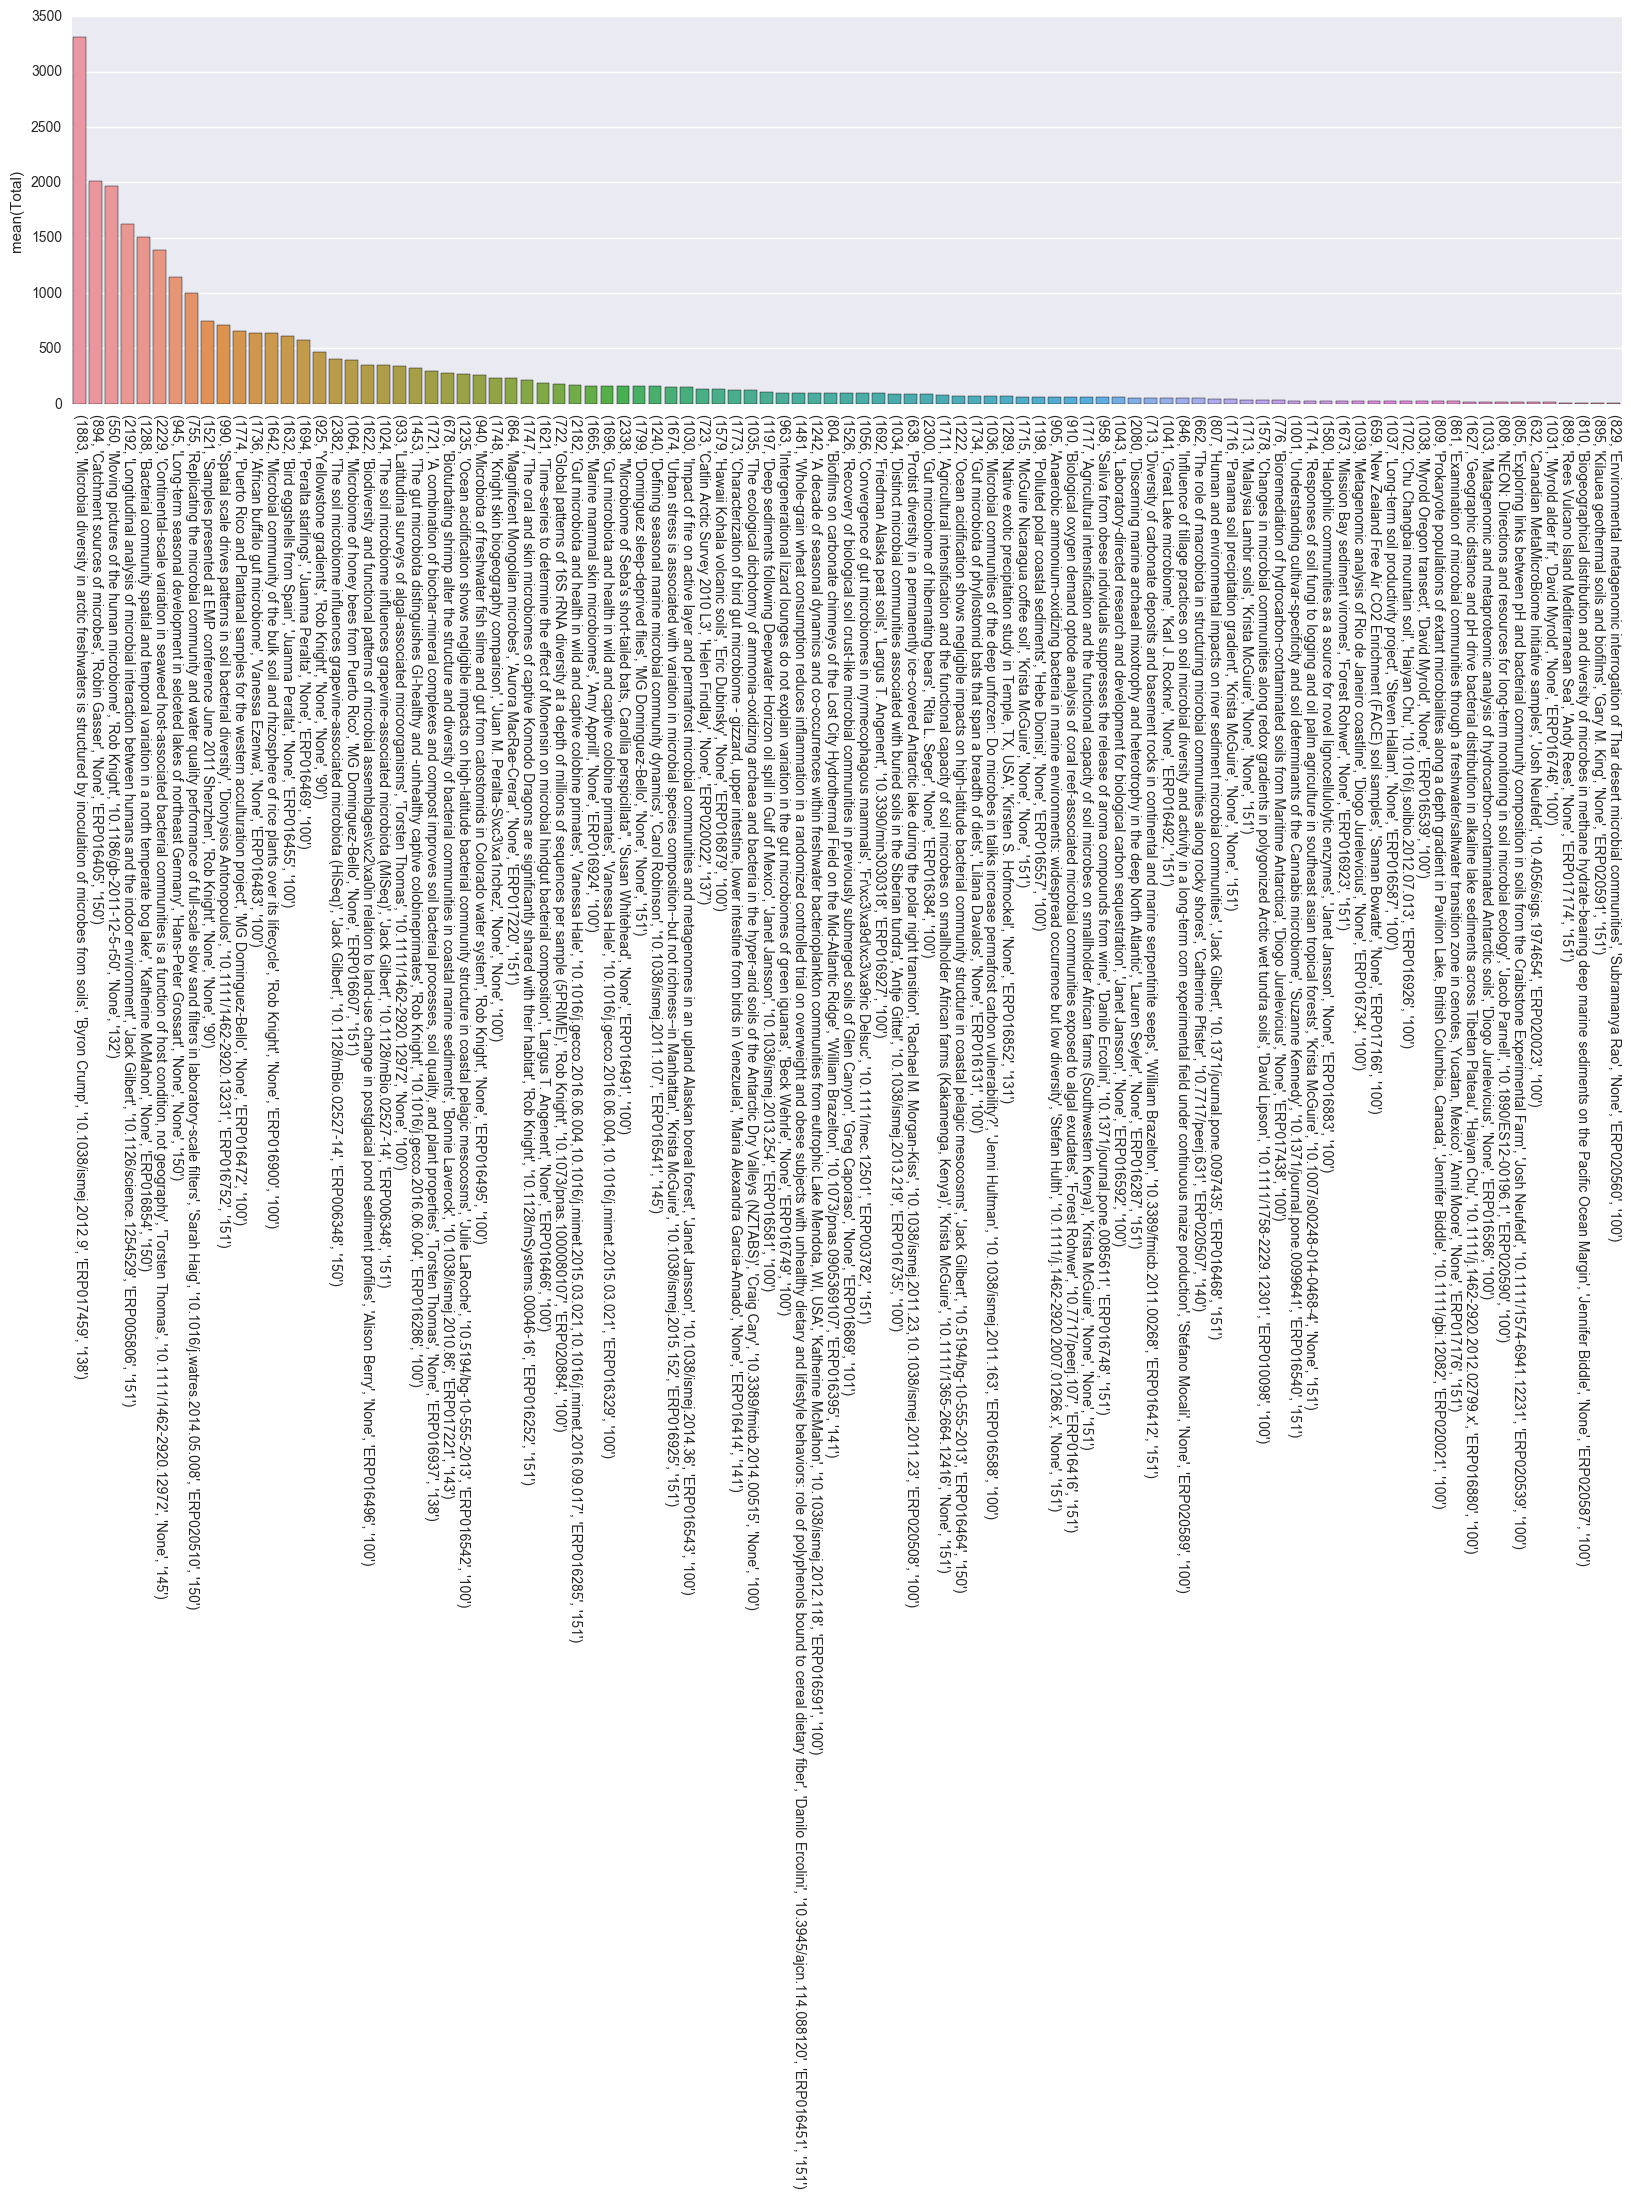

In [65]:
plt.figure(figsize=(20,5))
ph = sns.barplot(studies_groupby_unstack_sorted.index, studies_groupby_unstack_sorted)
for item in ph.get_xticklabels():
    item.set_rotation(270)

### Write merged refined mapping file

In [66]:
df_refined.to_csv('%s/emp_qiime_mapping_refined_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

In [67]:
# delete columns for internal use only
df_refined.drop('emp_paper', axis=1, inplace=True)
df_refined.drop('study_ok', axis=1, inplace=True)
df_refined.drop('dense_sampling', axis=1, inplace=True)
df_refined.drop('metadata_minimal', axis=1, inplace=True)
df_refined.drop('units_status', axis=1, inplace=True)

In [68]:
# write qc_filtered and subset mapping files
df_refined[df_refined.all_emp == True].to_csv('%s/emp_qiime_mapping_all_emp_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')
df_refined[df_refined.qc_filtered == True].to_csv('%s/emp_qiime_mapping_qc_filtered_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')
df_refined[df_refined.subset_10k == True].to_csv('%s/emp_qiime_mapping_subset_10k_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')
df_refined[df_refined.subset_5k == True].to_csv('%s/emp_qiime_mapping_subset_5k_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')
df_refined[df_refined.subset_2k == True].to_csv('%s/emp_qiime_mapping_subset_2k_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

### Split and write individual refined mapping files

In [69]:
studies = [line.rstrip('\n') for line in open(path_studies)]
for study in studies:
    df_individual = df_refined[df_refined.study_id == study]
    df_individual.to_csv('%s/qiime-maps-refined/%s_qiime_mapping_refined.tsv' % (path_outputdir, study), sep='\t')

### Write list of studies

In [70]:
emp_studies.to_csv('%s/emp_studies_no_controls_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')